Import some library

In [1]:
import os
import shutil
import cv2 #openCV lib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import StratifiedGroupKFold

# 1. Examine and understanding data

Some instruction:
- Images are stored in /storage/gcpproddata
- Metadata files are stored in /storage/experiments/matpatclassify/csv
- imagepaths.csv contains image paths (path), bag ids associated with image paths (bag) and the image locations (loc)
- bagsgucci.csv contains bag ids, materials (mat) and patterns (pat).
- You can try to merge those 2 files together by the bag column, then use mat and pat columns for labels.

## Import dataset

In [2]:
img_path = '/storage/gcpproddata/'
meta_path = '/storage/experiments/gucci-202202211437/csv/'
df = pd.read_csv(meta_path + 'imagepaths.csv')
df = df[df.location == 1]   # Only need data with location 1
df.shape                    # (69735,3)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72280 entries, 6 to 431670
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   path      72280 non-null  object
 1   bag       72280 non-null  object
 2   location  72280 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


In [3]:
df1 = df[['path','bag']]        # Path-bag dataset
df2 = pd.read_csv(meta_path + 'bagsgucci.csv')[['bag', 'mat']]   # Bag-mat dataset

Merge on 2 dataset

In [4]:
meta_df = df1.merge(df2, how='left', on='bag')              # Merge on 2 dataset
meta_df = meta_df.replace(r'^\s*$', np.NaN, regex=True)     # Replace all empty string by NULL
meta_df = meta_df.dropna(axis=0)
meta_df['fold'] = -1

In [6]:
sgkf = StratifiedGroupKFold(n_splits=5)

meta_df = df1.merge(df2, how='left', on='bag')              # Merge on 2 dataset
meta_df = meta_df.replace(r'^\s*$', np.NaN, regex=True)     # Replace all empty string by NULL
meta_df = meta_df.dropna(axis=0)
meta_df['fold'] = -1

for fold, (train_idxs, test_idxs) in enumerate(sgkf.split(X=meta_df['path'].values, 
                                                         y=meta_df['mat'].values, 
                                                         groups=meta_df['bag'])):
   meta_df.iloc[test_idxs, 3] = fold

meta_df = meta_df.drop("bag", axis= 1)
meta_df.head()

path                mat  fold
61  /storage/gcpproddata/images/sakata@komehyo.co....  gg supreme canvas     2
62  /storage/gcpproddata/images/sakata@komehyo.co....  gg supreme canvas     2
63  /storage/gcpproddata/images/sakata@komehyo.co....  gg supreme canvas     2
64  /storage/gcpproddata/images/sakata@komehyo.co....  gg supreme canvas     2
65  /storage/gcpproddata/images/sakata@komehyo.co....  gg supreme canvas     2

In [ ]:
# print(np.intersect1d(df.iloc[train_ids]['bag'].unique(), df.iloc[test_ids]['bag'].unique()))

In [ ]:
# meta_df = df1.merge(df2, how='left', on='bag').drop('bag', axis=1)  # Merge on 2 dataset
# meta_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69735 entries, 0 to 69734
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    69735 non-null  object
 1   mat     65144 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB


In [7]:
fold_chosen = 3
train_df = meta_df[meta_df.fold != fold_chosen]
val_df = meta_df[meta_df.fold == fold_chosen]
print(train_df.head())
print(val_df.head())

                                                 path                mat  fold
61  /storage/gcpproddata/images/sakata@komehyo.co....  gg supreme canvas     2
62  /storage/gcpproddata/images/sakata@komehyo.co....  gg supreme canvas     2
63  /storage/gcpproddata/images/sakata@komehyo.co....  gg supreme canvas     2
64  /storage/gcpproddata/images/sakata@komehyo.co....  gg supreme canvas     2
65  /storage/gcpproddata/images/sakata@komehyo.co....  gg supreme canvas     2
                                                  path           mat  fold
105  /storage/gcpproddata/images/sakata@komehyo.co....  flora canvas     3
106  /storage/gcpproddata/images/sakata@komehyo.co....  flora canvas     3
107  /storage/gcpproddata/images/sakata@komehyo.co....  flora canvas     3
108  /storage/gcpproddata/images/sakata@komehyo.co....  flora canvas     3
109  /storage/gcpproddata/images/sakata@komehyo.co....  flora canvas     3


In [8]:
train_df = train_df.drop("fold", axis=1)
val_df = val_df.drop("fold", axis=1)
print(train_df.head())
print(val_df.head())

                                                 path                mat
61  /storage/gcpproddata/images/sakata@komehyo.co....  gg supreme canvas
62  /storage/gcpproddata/images/sakata@komehyo.co....  gg supreme canvas
63  /storage/gcpproddata/images/sakata@komehyo.co....  gg supreme canvas
64  /storage/gcpproddata/images/sakata@komehyo.co....  gg supreme canvas
65  /storage/gcpproddata/images/sakata@komehyo.co....  gg supreme canvas
                                                  path           mat
105  /storage/gcpproddata/images/sakata@komehyo.co....  flora canvas
106  /storage/gcpproddata/images/sakata@komehyo.co....  flora canvas
107  /storage/gcpproddata/images/sakata@komehyo.co....  flora canvas
108  /storage/gcpproddata/images/sakata@komehyo.co....  flora canvas
109  /storage/gcpproddata/images/sakata@komehyo.co....  flora canvas


Content

In [9]:
train_labels = train_df['mat'].unique()
print(train_labels.shape)


(44,)


In [10]:
val_labels = val_df["mat"].unique()
print(val_labels.shape)

(34,)


In [11]:
labels = np.intersect1d(train_labels, val_labels)
print(labels.shape)

(31,)


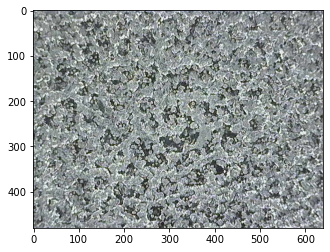

In [12]:
img = cv2.imread(df['path'].values[0])[..., ::-1]
img.shape       # (480,640,3)
plt.imshow(img)

# 2. Build inferred structure

## Build directory on my new folder 'intern'

In [13]:
# Function create directory
def create_dir(root_dir, class_dir):
    for i in class_dir:
        dirName = root_dir + '/' + str(i)
        try:
            os.makedirs(dirName)
            print("Directory", dirName, "Created")
        except FileExistsError:
            print("Directory", dirName, "already exists")

In [14]:
root_dir = "/storage/intern"
class_dir = ["mat"]
create_dir(root_dir="/storage/intern",
           class_dir=["train", "val"])

Directory /storage/intern/train Created
Directory /storage/intern/val Created


In [15]:
create_dir(root_dir="/storage/intern/train",
           class_dir=labels)
create_dir(root_dir="/storage/intern/val",
           class_dir=labels)

Directory /storage/intern/train/calf Created
Directory /storage/intern/train/canvas Created
Directory /storage/intern/train/canvas+leather Created
Directory /storage/intern/train/coatedcanvas Created
Directory /storage/intern/train/crocodile Created
Directory /storage/intern/train/denim Created
Directory /storage/intern/train/enamel Created
Directory /storage/intern/train/flora canvas Created
Directory /storage/intern/train/fur Created
Directory /storage/intern/train/gg crystal Created
Directory /storage/intern/train/gg embossed leather Created
Directory /storage/intern/train/gg imprime  Created
Directory /storage/intern/train/gg nylon Created
Directory /storage/intern/train/gg plus Created
Directory /storage/intern/train/gg supreme canvas Created
Directory /storage/intern/train/ggcanvas Created
Directory /storage/intern/train/guccissima Created
Directory /storage/intern/train/guccissima nylon Created
Directory /storage/intern/train/jacquard  Created
Directory /storage/intern/train/lea

## Transfer data to folder

In [16]:
# Loop for copy file train dataset
for i in range(len(labels)):
    mat_path = train_df[train_df['mat'] == labels[i]]['path']
    for j in range(len(mat_path)):
        img_path = mat_path.iloc[j]
        root_dir = "/storage/intern/train/"
        dir_name = root_dir + str(labels[i]) + '/' + str(j) +'.png'
        print(f"Copying from {img_path[8:]}, to {dir_name[8:]}")
        shutil.copyfile(src=img_path, dst=dir_name)

Copying from /gcpproddata/images/komehyosharing@gmail.com/bDAnfM/1/2.png, to /intern/train/calf/0.png
Copying from /gcpproddata/images/komehyosharing@gmail.com/bDAnfM/1/0.png, to /intern/train/calf/1.png
Copying from /gcpproddata/images/komehyosharing@gmail.com/bDAnfM/1/16.png, to /intern/train/calf/2.png
Copying from /gcpproddata/images/komehyosharing@gmail.com/bDAnfM/1/4.png, to /intern/train/calf/3.png
Copying from /gcpproddata/images/komehyosharing@gmail.com/bDAnfM/1/23.png, to /intern/train/calf/4.png
Copying from /gcpproddata/images/komehyosharing@gmail.com/bDAnfM/1/22.png, to /intern/train/calf/5.png
Copying from /gcpproddata/images/komehyosharing@gmail.com/bDAnfM/1/8.png, to /intern/train/calf/6.png
Copying from /gcpproddata/images/komehyosharing@gmail.com/bDAnfM/1/18.png, to /intern/train/calf/7.png
Copying from /gcpproddata/images/komehyosharing@gmail.com/bDAnfM/1/17.png, to /intern/train/calf/8.png
Copying from /gcpproddata/images/komehyosharing@gmail.com/bDAnfM/1/11.png, to

In [17]:
# Loop for copy file validation dataset
for i in range(len(labels)):
    mat_path = val_df[val_df['mat'] == labels[i]]['path']
    for j in range(len(mat_path)):
        img_path = mat_path.iloc[j]
        root_dir = "/storage/intern/val/"
        dir_name = root_dir + str(labels[i]) + '/' + str(j) +'.png'
        print(f"Copying from {img_path[8:]}, to {dir_name[8:]}")
        shutil.copyfile(src=img_path, dst=dir_name)

Copying from /gcpproddata/images/komehyosharing@gmail.com/yi1ctaATSfgUwqaPzwyE/1/2.png, to /intern/val/calf/0.png
Copying from /gcpproddata/images/komehyosharing@gmail.com/yi1ctaATSfgUwqaPzwyE/1/0.png, to /intern/val/calf/1.png
Copying from /gcpproddata/images/komehyosharing@gmail.com/yi1ctaATSfgUwqaPzwyE/1/16.png, to /intern/val/calf/2.png
Copying from /gcpproddata/images/komehyosharing@gmail.com/yi1ctaATSfgUwqaPzwyE/1/4.png, to /intern/val/calf/3.png
Copying from /gcpproddata/images/komehyosharing@gmail.com/yi1ctaATSfgUwqaPzwyE/1/23.png, to /intern/val/calf/4.png
Copying from /gcpproddata/images/komehyosharing@gmail.com/yi1ctaATSfgUwqaPzwyE/1/22.png, to /intern/val/calf/5.png
Copying from /gcpproddata/images/komehyosharing@gmail.com/yi1ctaATSfgUwqaPzwyE/1/8.png, to /intern/val/calf/6.png
Copying from /gcpproddata/images/komehyosharing@gmail.com/yi1ctaATSfgUwqaPzwyE/1/18.png, to /intern/val/calf/7.png
Copying from /gcpproddata/images/komehyosharing@gmail.com/yi1ctaATSfgUwqaPzwyE/1/17.